# TF-IDF Multi-label classifier

In [1]:
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
from sklearn import metrics

from data import constants

############################## CONFIG ##############################
CATEGORY_LEVEL = 'cro' #@param ["cro", "cro_sub_type_combined"]
AVERAGING_STRATEGY= 'macro' #@param ["micro",  "macro", "weighted"]
####################################################################

# To make the notebook reproducible (not guaranteed for pytorch on different releases/platforms!)
SEED_VALUE = 2


In [3]:
df_train = pd.read_pickle("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Labelling/annual reports/Firm_AnnualReport_Labels_Training.pkl")
df_test = pd.read_pickle("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Labelling/annual reports/Firm_AnnualReport_Labels_Test.pkl")
id_columns = ['report_id', 'page', 'paragraph_no']
df_train["id"] = df_train.apply(lambda row: "_".join([str(row[c]) for c in id_columns]), axis=1)
df_test["id"] = df_test.apply(lambda row: "_".join([str(row[c]) for c in id_columns]), axis=1)

# Set params
if CATEGORY_LEVEL == 'cro':
  category_labels = constants.cro_categories
  
  # Drop n/a's
  # df.query('cro == ["PR", "TR", "OP"]', inplace=True)
else:
  category_labels = constants.cro_sub_categories

  # df.query('cro_sub_type_combined.notnull() and cro_sub_type_combined != ""', inplace=True, engine='python')

no_of_categories = len(category_labels)
label_list = [c["label"] for c in category_labels]
label_code_list = [f'{c["code"]}_actual' for c in category_labels]

In [21]:
# The comparison hack is to filter NaN's, i.e. all the rows that were not labelled
df = df.query("labelling_dataset == labelling_dataset")

filter_str = " or ".join([f'{c} == {c}' for c in label_code_list])
# df_training_pos = df.query(f"labelling_dataset == 'training' & ({filter_str})")
df_pos = df.query(filter_str)

filter_str = " and ".join([f'{c} != {c}' for c in label_code_list])
df_neg = df.query(filter_str)

In [22]:
docs_train = df_train.text
docs_test = df_test.text
labels_train = df_train[label_code_list]
labels_test = df_test[label_code_list]

labels_train = (labels_train > 0) * 1
labels_test = (labels_test > 0) * 1

In [23]:
# TEMPORARY - Load
# Load classifier
import pickle

with open(os.path.join("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Models/stoxx_inference", 'multilabel_svm_cro.pkl'), 'rb') as f:
    grid_clf = pickle.load(f)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import shuffle

docs_train, labels_train = shuffle(docs_train, labels_train, random_state=SEED_VALUE)

pipeline_svm = Pipeline([
    ('bow', CountVectorizer(strip_accents = 'ascii')),
    ('tfidf', TfidfTransformer()),
    ('classifier', OneVsRestClassifier(
        SVC(probability=True, random_state=SEED_VALUE))
    ), # Note: Nested estimator
     ])

# Parameters to tune automatically with a grid search
# Note: The nested estimator is accessible via the __estimator identifier
param_svm = [
  {
      'bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
      'bow__max_features': [None, 50, 200],
      'bow__stop_words': ['english', None],
      'tfidf__use_idf': (True, False),
      'classifier__estimator__C': [1, 10, 100], 
      'classifier__estimator__kernel': ['linear', 'rbf']},
]

grid_clf = GridSearchCV(
    pipeline_svm,
    param_grid=param_svm,
    refit=True,
    n_jobs=-1, 
    scoring='roc_auc', # 'roc_auc' gives an error
    # cv=StratifiedKFold(label_train, n_folds=5),
)

# Grid search fitting
grid_clf.fit(docs_train, labels_train)

In [24]:
cv_results = pd.DataFrame(grid_clf.cv_results_)

print(f"Best score: {grid_clf.best_score_}")
print(f"Best params: \n{grid_clf.best_params_}")

Best score: 0.9704081665700268
Best params: 
{'bow__ngram_range': (1, 3), 'classifier__estimator__C': 10, 'classifier__estimator__kernel': 'linear', 'tfidf__use_idf': True}


In [25]:
# Predict for test
preds = grid_clf.predict(docs_test)
preds_prob = grid_clf.predict_proba(docs_test)

In [22]:
# Run prediction on the test set.
threshold = 0.5
preds_bool = (preds > threshold)

# Use the accuracy and F1 metric to score our classifier's performance on the test set.
accuracy = metrics.accuracy_score(labels_test, preds)
score = metrics.f1_score(labels_test, preds, average=AVERAGING_STRATEGY)
roc_auc = metrics.roc_auc_score(labels_test, preds_prob, average=AVERAGING_STRATEGY)

cms = metrics.multilabel_confusion_matrix(labels_test, preds_bool)
print(metrics.classification_report(labels_test, preds_bool, target_names=label_list))

print(f"Accuracy: {accuracy}, F1: {score}, RoC AUC: {roc_auc}")

              precision    recall  f1-score   support

          PR       0.08      0.77      0.15        26
          TR       0.10      0.61      0.17        36
          OP       0.00      0.95      0.01        21

   micro avg       0.01      0.75      0.03        83
   macro avg       0.06      0.78      0.11        83
weighted avg       0.07      0.75      0.12        83
 samples avg       0.00      0.00      0.00        83

Accuracy: 0.8367129892229155, F1: 0.1097382599998694, RoC AUC: 0.9731291953289695


/Users/david/Projects/fin-disclosures-nlp/envs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/david/Projects/fin-disclosures-nlp/envs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


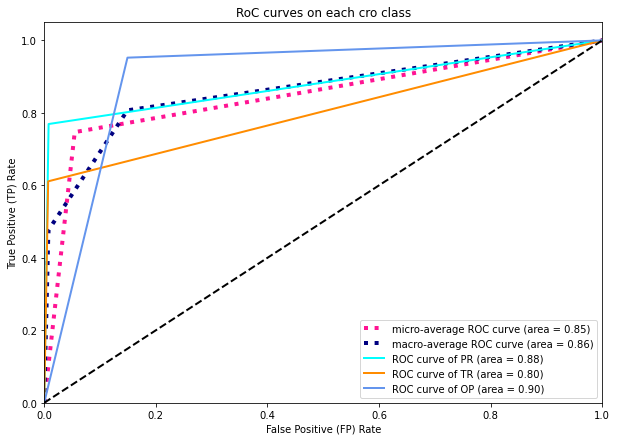

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

n_classes = no_of_categories
preds = preds
labels = labels_test.to_numpy()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # roc_auc = metrics.roc_auc_score(labels_test, preds_prob, average=AVERAGING_STRATEGY)
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# roc_auc = metrics.roc_auc_score(labels_test, preds_prob, average=AVERAGING_STRATEGY)
fpr["micro"], tpr["micro"], _ = roc_curve(labels.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2

# Plot all ROC curves
plt.figure(figsize = (10,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'blue', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(label_list[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive (FP) Rate')
plt.ylabel('True Positive (TP) Rate')
plt.title(f'RoC curves on each {CATEGORY_LEVEL} class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pickle

with open(f"/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Models/stoxx_inference/multilabel_svm_{CATEGORY_LEVEL}.pkl", 'wb') as f:
    grid_clf.label_list = label_list
    pickle.dump(grid_clf, f, 4)


##########

In [ ]:


# Set counts to binary 1/0
doc_labels = (doc_labels > 0) * 1
doc_labels.to_numpy()

# Ensure the docs and labels are the same shape
assert np.shape(docs)[0] == np.shape(doc_labels)[0]
    
train_dataset = pd.DataFrame(docs, columns=['text'])
train_dataset['labels'] = doc_labels.values.tolist()

train_neg_dataset['labels'] = np.zeros((np.shape(train_neg_dataset)[0], no_of_categories), dtype=np.int8).tolist()
train_neg_dataset = train_neg_dataset.sample(600, random_state=SEED_VALUE)

# Set texts and labels
docs = train_dataset.text
doc_labels = train_dataset.labels

# Add some negative examples
docs = pd.concat([docs, train_neg_dataset.text])
doc_labels = pd.concat([doc_labels, train_neg_dataset.labels])


In [ ]:
# Load data
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_pickle("/content/drive/My Drive/fin-disclosures-nlp/data/labels/Firm_AnnualReport_Labels_100_combined.pkl")
df = pd.read_pickle("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Labelling/annual reports/Firm_AnnualReport_Labels_Training_Positive.pkl")
df_neg = pd.read_pickle("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Labelling/annual reports/Firm_AnnualReport_Labels_Training_Negative.pkl")


# Set id
id_columns = ['report_id', 'page', 'paragraph_no']
df["id"] = df.apply(lambda row: "_".join([str(row[c]) for c in id_columns]), axis=1)
df_neg["id"] = df_neg.apply(lambda row: "_".join([str(row[c]) for c in id_columns]), axis=1)

# Set params
if CATEGORY_LEVEL == 'cro':
  category_labels = [{"code": "PR", "label": "PR"}, {"code": "TR", "label": "TR"}, {"code": "OP", "label": "OP"}]
  
  # Drop n/a's
  df.query('cro == ["PR", "TR", "OP"]', inplace=True)
  no_of_categories = len(df.cro.unique())
else:
  category_labels = [{"code": "ACUTE", "label": "PR - Acute"}, {"code": "CHRON", "label": "PR - Chronic"}, 
                     {"code": "POLICY", "label": "TR - Policy"}, {"code": "MARKET", "label": "TR - Market & Technology"}, {"code": "REPUTATION", "label": "TR - Reputation"},
                     {"code": "PRODUCTS", "label": "OP - Products, Services & Markets"}, {"code": "RESILIENCE", "label": "OP - Resource Efficiency & Resilience"}]
  
  df.query('cro_sub_type_combined.notnull() and cro_sub_type_combined != ""', inplace=True, engine='python')
  no_of_categories = len(df.cro_sub_type_combined.unique())

label_list = [c["label"] for c in category_labels]

# Verification that there are no unlabelled/unwanted categories
assert len(category_labels) == no_of_categories


# Prepare negative dataset
neg_docs = df_neg.groupby(["id"]).first().text
assert neg_docs.shape[0] == df_neg.shape[0]
train_neg_dataset = pd.DataFrame(neg_docs, columns=['text'])

docs = df.groupby(["id"]).first().text
doc_labels = pd.crosstab(df.id, df[CATEGORY_LEVEL], dropna=False)
doc_labels = doc_labels[map(lambda c: c['code'], category_labels)]

# Set counts to binary 1/0
doc_labels = (doc_labels > 0) * 1
doc_labels.to_numpy()

# Ensure the docs and labels are the same shape
assert np.shape(docs)[0] == np.shape(doc_labels)[0]
    
train_dataset = pd.DataFrame(docs, columns=['text'])
train_dataset['labels'] = doc_labels.values.tolist()

train_neg_dataset['labels'] = np.zeros((np.shape(train_neg_dataset)[0], no_of_categories), dtype=np.int8).tolist()
train_neg_dataset = train_neg_dataset.sample(600, random_state=SEED_VALUE)

# Set texts and labels
docs = train_dataset.text
doc_labels = train_dataset.labels

# Add some negative examples
docs = pd.concat([docs, train_neg_dataset.text])
doc_labels = pd.concat([doc_labels, train_neg_dataset.labels])

doc_labels = np.vstack(doc_labels[:,])

In [ ]:
doc_labels.sum(axis=0)

In [ ]:
from sklearn.model_selection import train_test_split

# Split to train/test (temporary)
X_train, X_test, y_train, y_test = train_test_split(docs, doc_labels, test_size=0.1, random_state=SEED_VALUE)

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the 2 datasets using tf-idf.
# vectorizer = TfidfVectorizer()
# vectors_train = vectorizer.fit_transform(X_train)
# vectors_test = vectorizer.transform(X_test)


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

# clf = OneVsRestClassifier(SVC(kernel='linear', random_state=SEED_VALUE), probability=True)
# clf.fit(vectors_train, y_train)
# preds = clf.predict(vectors_test)
# preds_prob = clf.predict_proba(vectors_test)

In [ ]:
y_test.sum(axis=0)

In [ ]:
print(f"Accuracy: {accuracy}, F1: {score}, RoC AUC: {roc_auc}")

In [16]:
df_cleaned = df_cleaned.drop(['firm_name', 'ticker', 'country', 'icb_industry', 'icb_supersector', 'should_infer', 'is_inferred', 'company', 'orig_report_type', 'report_type', 'year', 'input_file', 'output_file', 'company_id'], axis=1)

In [15]:
df_cleaned

Index(['page_no', 'paragraph_no', 'text', 'is_adjunct', 'report_id', 'company',
       'orig_report_type', 'report_type', 'year', 'input_file', 'output_file',
       'should_infer', 'is_inferred', 'company_id', 'firm_name', 'ticker',
       'country', 'icb_industry', 'icb_supersector', 'labelling_dataset', 'id',
       'OP_actual', 'PR_actual', 'TR_actual', 'ACUTE_actual', 'CHRON_actual',
       'MARKET_actual', 'POLICY_actual', 'PRODUCTS_actual',
       'REPUTATION_actual', 'RESILIENCE_actual'],
      dtype='object')

In [17]:
cols = list(df_cleaned.columns.values)
cols
# df = df[['mean', '0', '1', '2', '3']]

['page_no',
 'paragraph_no',
 'text',
 'is_adjunct',
 'report_id',
 'labelling_dataset',
 'id',
 'OP_actual',
 'PR_actual',
 'TR_actual',
 'ACUTE_actual',
 'CHRON_actual',
 'MARKET_actual',
 'POLICY_actual',
 'PRODUCTS_actual',
 'REPUTATION_actual',
 'RESILIENCE_actual']

In [18]:
df_cleaned.id

0         dk_novo_nordisk_b-AR_2016_6_0
1         dk_novo_nordisk_b-AR_2016_6_1
2         dk_novo_nordisk_b-AR_2016_6_2
3         dk_novo_nordisk_b-AR_2016_6_3
4         dk_novo_nordisk_b-AR_2016_6_4
                      ...              
627996       ch_novartis-AR_2018_245_10
627997       ch_novartis-AR_2018_245_11
627998       ch_novartis-AR_2018_245_12
627999       ch_novartis-AR_2018_245_13
628000       ch_novartis-AR_2018_245_14
Name: id, Length: 628001, dtype: object

In [ ]:
df_output = df_cleaned[['id', 'report_id', 'page_no', 'paragraph_no', 'labelling_dataset', 'coder', 'negative_type', 'is_adjunct', 'text', 'PR_actual', 'TR_actual', 'OP_actual', 'ACUTE_actual', 'CHRON_actual', 'REPUTATION_actual', 'MARKET_actual', 'POLICY_actual', 'PRODUCTS_actual', 'RESILIENCE_actual']]